In [ ]:
# based on
# https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_stmnist.html

In [1]:
# tonic imports
import tonic
import tonic.transforms as transforms  # Not to be mistaken with torchdata.transfroms
from tonic import DiskCachedDataset

# torch imports
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn

# snntorch imports
import snntorch as snn
from snntorch import surrogate
import snntorch.spikeplot as splt
from snntorch import functional as SF
from snntorch import utils

# other imports
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display
import numpy as np
import torchdata
import os
from ipywidgets import IntProgress
import time
import statistics

In [8]:
root = '/Users/dmartins/Desktop'

In [9]:
dataset = tonic.prototype.datasets.STMNIST(root=root, keep_compressed=False, shuffle=False)

In [10]:
sensor_size = tonic.prototype.datasets.STMNIST.sensor_size
sensor_size = tuple(sensor_size.values())

# Define a transform
frame_transform = transforms.Compose([transforms.ToFrame(sensor_size=sensor_size, time_window=20000)])

In [11]:
def shorter_transform_STMNIST(data, transform):
    short_train_size = 640
    short_test_size = 320

    train_bar = IntProgress(min=0, max=short_train_size)
    test_bar = IntProgress(min=0, max=short_test_size)

    testset = []
    trainset = []

    print('Porting over and transforming the trainset.')
    display(train_bar)
    for _ in range(short_train_size):
        events, target = next(iter(dataset))
        events = transform(events)
        trainset.append((events, target))
        train_bar.value += 1
    print('Porting over and transforming the testset.')
    display(test_bar)
    for _ in range(short_test_size):
        events, target = next(iter(dataset))
        events = transform(events)
        testset.append((events, target))
        test_bar.value += 1

    return (trainset, testset)

start_time = time.time()
trainset, testset = shorter_transform_STMNIST(dataset, frame_transform)
elapsed_time = time.time() - start_time

# Convert elapsed time to minutes, seconds, and milliseconds
minutes, seconds = divmod(elapsed_time, 60)
seconds, milliseconds = divmod(seconds, 1)
milliseconds = round(milliseconds * 1000)

# Print the elapsed time
print(f"Elapsed time: {int(minutes)} minutes, {int(seconds)} seconds, {milliseconds} milliseconds")

Porting over and transforming the trainset.


IntProgress(value=0, max=640)

Porting over and transforming the testset.


IntProgress(value=0, max=320)

Elapsed time: 0 minutes, 19 seconds, 290 milliseconds


In [12]:
dataloader = DataLoader(trainset, batch_size=32, shuffle=True)

In [13]:
transform = tonic.transforms.Compose([torch.from_numpy])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/stmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/stmnist/test')

batch_size = 32
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

In [14]:
data_tensor, targets = next(iter(trainloader))
print(data_tensor.shape)

torch.Size([86, 32, 2, 10, 10])


In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
beta = 0.95

# This is the same architecture that was used in the STMNIST Paper
scnn_net = nn.Sequential(
    nn.Conv2d(2, 32, kernel_size=4),
    snn.Leaky(beta=beta, init_hidden=True),
    nn.Conv2d(32, 64, kernel_size=3),
    snn.Leaky(beta=beta, init_hidden=True),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 2 * 2, 10),  # Increased size of the linear layer
    snn.Leaky(beta=beta, init_hidden=True, output=True)
).to(device)

optimizer = torch.optim.Adam(scnn_net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [16]:
def forward_pass(net, data):
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    for step in range(data.size(0)):  # data.size(0) = number of time steps

        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)

    return torch.stack(spk_rec)

In [17]:
start_time = time.time()

num_epochs = 30

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        scnn_net.train()
        spk_rec = forward_pass(scnn_net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print loss every 4 iterations
        if i%4 == 0:
            print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        # Calculate accuracy rate and then append it to accuracy history
        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        # Print accuracy every 4 iterations
        if i%4 == 0:
            print(f"Accuracy: {acc * 100:.2f}%\n")

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to minutes, seconds, and milliseconds
minutes, seconds = divmod(elapsed_time, 60)
seconds, milliseconds = divmod(seconds, 1)
milliseconds = round(milliseconds * 1000)

# Print the elapsed time
print(f"Elapsed time: {int(minutes)} minutes, {int(seconds)} seconds, {milliseconds} milliseconds")

Epoch 0, Iteration 0 
Train Loss: 8.73
Accuracy: 12.50%

Epoch 0, Iteration 4 
Train Loss: 7.68
Accuracy: 18.75%

Epoch 0, Iteration 8 
Train Loss: 8.04
Accuracy: 6.25%

Epoch 0, Iteration 12 
Train Loss: 5.18
Accuracy: 12.50%

Epoch 0, Iteration 16 
Train Loss: 3.67
Accuracy: 9.38%

Epoch 1, Iteration 0 
Train Loss: 3.50
Accuracy: 9.38%

Epoch 1, Iteration 4 
Train Loss: 3.67
Accuracy: 18.75%

Epoch 1, Iteration 8 
Train Loss: 3.10
Accuracy: 18.75%

Epoch 1, Iteration 12 
Train Loss: 3.38
Accuracy: 12.50%

Epoch 1, Iteration 16 
Train Loss: 3.65
Accuracy: 6.25%

Epoch 2, Iteration 0 
Train Loss: 3.28
Accuracy: 9.38%

Epoch 2, Iteration 4 
Train Loss: 3.08
Accuracy: 21.88%

Epoch 2, Iteration 8 
Train Loss: 3.27
Accuracy: 15.62%

Epoch 2, Iteration 12 
Train Loss: 3.07
Accuracy: 18.75%

Epoch 2, Iteration 16 
Train Loss: 2.95
Accuracy: 15.62%

Epoch 3, Iteration 0 
Train Loss: 3.19
Accuracy: 25.00%

Epoch 3, Iteration 4 
Train Loss: 3.02
Accuracy: 31.25%

Epoch 3, Iteration 8 
Train Lo

In [18]:
torch.save(scnn_net.state_dict(), 'scnn_net.pth')

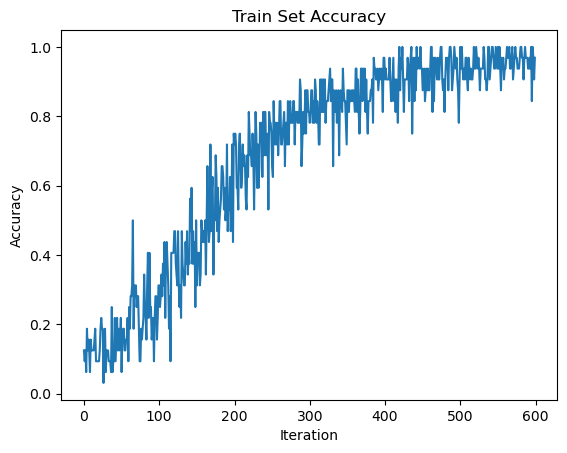

In [19]:
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [20]:
# Make sure your model is in evaluation mode
scnn_net.eval()

# Initialize variables to store predictions and ground truth labels
acc_hist = []

# Iterate over batches in the testloader
with torch.no_grad():
    for data, targets in testloader:
        # Move data and targets to the device (GPU or CPU)
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        spk_rec = forward_pass(scnn_net, data)

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        # if i%10 == 0:
        # print(f"Accuracy: {acc * 100:.2f}%\n")

print("The average loss across the testloader is:", statistics.mean(acc_hist))

The average loss across the testloader is: 0.65625


In [26]:
scnn_net

Sequential(
  (0): Conv2d(2, 32, kernel_size=(4, 4), stride=(1, 1))
  (1): Leaky()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): Leaky()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=256, out_features=10, bias=True)
  (7): Leaky()
)

In [30]:
len(trainset)

640

In [38]:
trainset[0][1]

9

In [39]:
trainset[0][0].shape

(75, 2, 10, 10)